# Text Analysis

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Pyspark Modelling") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df = spark.read.csv('Data/Cleaned_data.csv', header= True, inferSchema= True, multiLine=True, quote='"', escape='"')

In [2]:
text_analysis = df.select('Desc', 'price')
text_analysis.show()

+--------------------+-----+
|                Desc|price|
+--------------------+-----+
|The birdhouse.Swe...|160.0|
|Charming 1929 hom...| 60.0|
|Private Room "Hit...| 71.0|
|Cottage McIntyre ...|124.0|
|       The Zen Cabin| 88.0|
|Gorgeous home on ...|354.0|
|Tour the Blue Rid...| 81.0|
|Old World Charm, ...|158.0|
|Celia's Retreat I...|253.0|
|SXSW - musician's...|100.0|
|New Resort Style ...|164.0|
|Bright E 6th St D...|114.0|
|Entire Guest Suit...| 83.0|
|eastside charm by...|285.0|
|Quarters 2 blocks...| 40.0|
|Filmmaker High-en...| 67.0|
|Private room  in ...| 27.0|
|SXSW Special Hist...|250.0|
|1 Br Elegant Down...|900.0|
|   Austin Tree House|281.0|
+--------------------+-----+
only showing top 20 rows



In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [4]:
# Clean text
df_clean = text_analysis.select('price', (lower(regexp_replace('Desc', "[^a-zA-Z\\s]", "")).alias('Desc')))
df_clean.show()

+-----+--------------------+
|price|                Desc|
+-----+--------------------+
|160.0|the birdhouseswee...|
| 60.0|charming  home w ...|
| 71.0|private room hitc...|
|124.0|cottage mcintyre ...|
| 88.0|       the zen cabin|
|354.0|gorgeous home on ...|
| 81.0|tour the blue rid...|
|158.0|old world charm c...|
|253.0|celias retreat i ...|
|100.0|sxsw  musicians home|
|164.0|new resort style ...|
|114.0|bright e th st do...|
| 83.0|entire guest suit...|
|285.0|eastside charm by...|
| 40.0|quarters  blocks ...|
| 67.0|filmmaker highend...|
| 27.0|private room  in ...|
|250.0|sxsw special hist...|
|900.0| br elegant downt...|
|281.0|   austin tree house|
+-----+--------------------+
only showing top 20 rows



In [5]:
# Tokenize text
tokenizer = Tokenizer(inputCol='Desc', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select('price', 'words_token')
# Remove stop words
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('price', 'words_clean')

# Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
df_final_words = df_words_no_stopw.withColumn('words', filter_length_udf(col('words_clean'))).select('price', 'words')

In [6]:
df_final_words.show()

+-----+--------------------+
|price|               words|
+-----+--------------------+
|160.0|[birdhousesweet, ...|
| 60.0|[charming, home, ...|
| 71.0|[private, room, h...|
|124.0|[cottage, mcintyr...|
| 88.0|        [zen, cabin]|
|354.0|[gorgeous, home, ...|
| 81.0|[tour, blue, ridg...|
|158.0|[old, world, char...|
|253.0|[celias, retreat,...|
|100.0|[sxsw, musicians,...|
|164.0|[new, resort, sty...|
|114.0|[bright, downtown...|
| 83.0|[entire, guest, s...|
|285.0|[eastside, charm,...|
| 40.0|[quarters, blocks...|
| 67.0|[filmmaker, highe...|
| 27.0|[private, room, f...|
|250.0|[sxsw, special, h...|
|900.0|[elegant, downtow...|
|281.0|[austin, tree, ho...|
+-----+--------------------+
only showing top 20 rows



In [7]:
df_cheap = df_final_words.filter(col('price')<=1000)
df_normal = df_final_words.filter((col('price')>1000) & (col('price')<=12500))
df_expensive = df_final_words.filter((col('price')>12500) & (col('price')<=20000))
df_luxury = df_final_words.filter(col('price')>20000)

In [8]:
cheap = list(df_cheap.select('words').toPandas()['words'])
normal = list(df_normal.select('words').toPandas()['words'])
expensive = list(df_expensive.select('words').toPandas()['words'])
luxury = list(df_luxury.select('words').toPandas()['words'])

In [9]:
def word_cloud_text(all_text):
    all_text_cleaned = []
    for text in all_text:
        all_text_cleaned.append(text)
    text_desc = [" ".join(text) for text in all_text_cleaned]
    final_text_desc = " ".join(text_desc)
    return final_text_desc

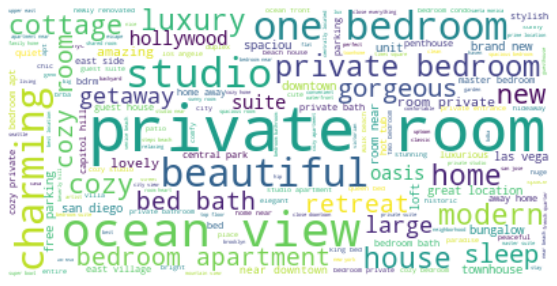

In [10]:
final_text_desc = word_cloud_text(cheap)
wordcloud = WordCloud(background_color ='white', stopwords = STOPWORDS, collocations=True).generate(final_text_desc)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()
wordcloud.to_file('Figures/'+"cheap"+'_accomodations.png') 

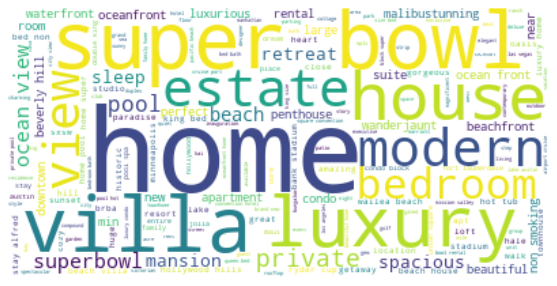

In [11]:
final_text_desc = word_cloud_text(normal)
wordcloud = WordCloud(background_color ='white', stopwords = STOPWORDS, collocations=True).generate(final_text_desc)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()
wordcloud.to_file('Figures/'+"normal"+'_accomodations.png') 

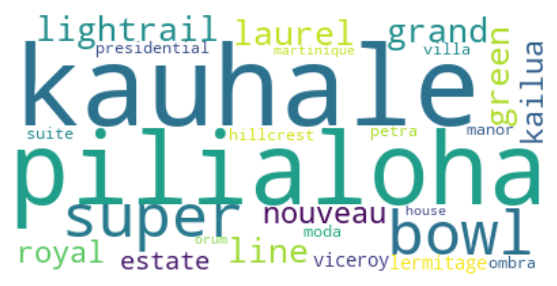

In [12]:
#cloud_texts = ['cheap', 'normal', 'expensive', 'luxury']

final_text_desc = word_cloud_text(expensive)
wordcloud = WordCloud(background_color ='white', stopwords = STOPWORDS, collocations=True).generate(final_text_desc)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()
wordcloud.to_file('Figures/'+"expensive"+'_accomodations.png') 

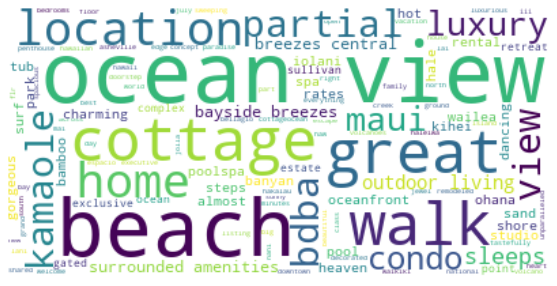

In [13]:
final_text_desc = word_cloud_text(luxury)
wordcloud = WordCloud(background_color ='white', stopwords = STOPWORDS, collocations=True).generate(final_text_desc)
plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()
wordcloud.to_file('Figures/'+"luxury"+'_accomodations.png') 